In [310]:
import soundfile as sf
import numpy as np

noisy_sensor_tuple = sf.read('resources/noisySensor.wav')

In [311]:
sampling_rate = noisy_sensor_tuple[1]
sampling_rate

16000

In [312]:
noisy_sensor_data = noisy_sensor_tuple[0]
noisy_sensor_data

array([[ 0.00793457,  0.03259277, -0.00076294,  0.0027771 ],
       [ 0.00717163, -0.01785278,  0.00039673,  0.0300293 ],
       [ 0.00408936, -0.00509644, -0.00576782, -0.00244141],
       ...,
       [-0.01037598,  0.00057983, -0.02798462, -0.01687622],
       [ 0.00997925, -0.00830078,  0.00979614, -0.02633667],
       [-0.02468872, -0.01419067,  0.00164795, -0.00024414]])

In [313]:
noisy_sensor_data.shape

(109466, 4)

In [314]:
frame_length = 128
frame_shift = 32
frame_length_samples = frame_length * sampling_rate / 1000
num_mics = noisy_sensor_data.shape[1]
num_mics

4

In [315]:
def my_windowing(v_signal: np.ndarray, sampling_rate: int, frame_length: int, frame_shift: int) -> [np.ndarray, np.ndarray]:
    millis_per_sample = 1000 / sampling_rate
    frame_length_num_points = frame_length / millis_per_sample
    frame_shift_num_points = frame_shift / millis_per_sample
    num_frames = int(np.floor((len(v_signal) - frame_length_num_points) / frame_shift_num_points) + 1)
    m_frames = np.zeros((num_frames, int(frame_length_num_points)))
    v_time_frame = np.zeros(num_frames)
    for i in range(num_frames):
        start = int(i * frame_shift_num_points)
        end = int(i * frame_shift_num_points + frame_length_num_points)
        m_frames[i] = v_signal[start:end]
        v_time_frame[i] = (start + end)/(2*sampling_rate)
    return [m_frames, v_time_frame]

In [316]:
def compute_freq_axis(m_stft: np.ndarray):
    return np.linspace(0, sampling_rate//2, num=m_stft.shape[1])

def remove_upper_half_spectrum(m_stft: np.ndarray) -> np.ndarray:
    m_stft_new = m_stft[:, :(int(m_stft.shape[1]/2)+1)]
    return m_stft_new

In [317]:
def compute_stft(v_signal: np.ndarray, fs: int, frame_length: int, frame_shift: int, v_analysis_window: np.ndarray) -> [np.ndarray, np.ndarray, np.ndarray]:
    m_frames, v_time_frame = my_windowing(v_signal, fs, frame_length, frame_shift)
    m_stft_full = np.zeros(m_frames.shape, dtype=np.complex128)
    #v_analysis_window = v_analysis_window(m_frames.shape[1])
    for i in range(m_frames.shape[0]):
        m_stft_full[i] = np.fft.fft(m_frames[i]*v_analysis_window)
    #v_freq = np.fft.rfftfreq(m_stft_full.shape[1], 1/fs)
    m_stft = remove_upper_half_spectrum(m_stft_full)
    v_freq = compute_freq_axis(m_stft)
    return [m_stft, v_freq, v_time_frame]

In [318]:
from scipy.signal import get_window

hann_window = get_window('hann', int(frame_length_samples), fftbins=True)
root_hann = np.sqrt(hann_window)
analysis_window = root_hann
synthesis_window = root_hann*0.5

In [319]:
noisy_sensor_data[:, 0]

array([ 0.00793457,  0.00717163,  0.00408936, ..., -0.01037598,
        0.00997925, -0.02468872])

In [320]:
m_stft_all, v_freq_all, v_time_frame_all = list(), list(), list()

for i in range(num_mics):
    m_stft, v_freq, v_time_frame = compute_stft(noisy_sensor_data[:, i], sampling_rate, frame_length, frame_shift, analysis_window)
    m_stft_all.append(m_stft)
    v_freq_all.append(v_freq)
    v_time_frame_all.append(v_time_frame)

m_stft_all = np.array(m_stft_all)
v_freq_all = np.array(v_freq_all)
v_time_frame_all = np.array(v_time_frame_all)

In [321]:
m_stft_all[0]

array([[-0.21444179+0.j        , -0.10201128+0.06569596j,
         0.02337702-0.27094087j, ..., -0.23648172-0.46803554j,
         0.19378406+0.58663878j, -0.23064906+0.j        ],
       [-0.20392689+0.j        ,  0.09443936-0.11705229j,
        -0.2185066 +0.40445821j, ..., -0.36589365+0.32330495j,
         0.37382761-0.49542409j, -0.26674322+0.j        ],
       [-0.36690386+0.j        ,  0.00119601+0.00398795j,
         0.24996747-0.31884857j, ...,  0.68973617-0.23510823j,
        -0.38682075+0.02485391j, -0.12573747+0.j        ],
       ...,
       [-0.34605201+0.j        , -0.06293332+1.00800528j,
         0.1525655 -0.78994368j, ...,  0.11462281-0.42049714j,
         0.00301734+0.50879125j,  0.11103691+0.j        ],
       [ 0.4346035 +0.j        , -0.37989209-0.08702199j,
         0.11286405+0.86164713j, ..., -0.18587565+0.21741769j,
         0.47198853-0.22507645j,  0.02882088+0.j        ],
       [ 0.82634186+0.j        , -0.13180145+0.35576256j,
        -0.28011365-0.72373166

In [322]:
m_stft_all[0].shape

(210, 1025)

2.2) The synthesis window is multiplied by one half to compensate for the overlap of the windows. The synthesis window is then applied to the STFT of the noisy signal to obtain the reconstructed signal.

In [323]:
def compute_time_delay(d, i, theta):
    c = 340
    t = i*d*np.cos(theta) / c
    return t

In [324]:
theta = np.pi/4
d = 0.05
ts = np.array([compute_time_delay(d, i, theta) for i in range(num_mics)])
ts

array([0.        , 0.00010399, 0.00020797, 0.00031196])

In [325]:
v_freq_all.shape[1]

1025

It is the correct formula because there is a right angle can be projected between two sensors and then we can calculate the time difference using triangulation.

In [326]:
def compute_steering_vector(fs, t):
    N = v_freq_all.shape[1]
    a = np.zeros((N, 4), dtype=np.complex128)
    for k in range(N):
        a[k][0] = 1
        for i in range(1, 4):
            a[k][i] = np.exp((-1j*2*np.pi*k*fs*t[i])/N)
    return a

In [327]:
a = compute_steering_vector(sampling_rate, ts)
a

array([[ 1.        +0.j        ,  1.        +0.j        ,
         1.        +0.j        ,  1.        +0.j        ],
       [ 1.        +0.j        ,  0.99994799-0.01019869j,
         0.99979197-0.02039633j,  0.99953196-0.03059184j],
       [ 1.        +0.j        ,  0.99979197-0.02039633j,
         0.99916798-0.04078417j,  0.99812828-0.06115504j],
       ...,
       [ 1.        +0.j        , -0.54159111+0.84064206j,
        -0.41335814-0.91056853j,  0.9893333 +0.14566959j],
       [ 1.        +0.j        , -0.53298949+0.84612186j,
        -0.4318444 -0.90194812j,  0.99332655+0.11533589j],
       [ 1.        +0.j        , -0.52433244+0.85151365j,
        -0.45015099-0.89295245j,  0.99638997+0.08489422j]])

In [328]:
ah = np.conjugate(a).T
ah.shape

(4, 1025)

In [329]:
ah[:,]

array([[ 1.        -0.j        ,  1.        -0.j        ,
         1.        -0.j        , ...,  1.        -0.j        ,
         1.        -0.j        ,  1.        -0.j        ],
       [ 1.        -0.j        ,  0.99994799+0.01019869j,
         0.99979197+0.02039633j, ..., -0.54159111-0.84064206j,
        -0.53298949-0.84612186j, -0.52433244-0.85151365j],
       [ 1.        -0.j        ,  0.99979197+0.02039633j,
         0.99916798+0.04078417j, ..., -0.41335814+0.91056853j,
        -0.4318444 +0.90194812j, -0.45015099+0.89295245j],
       [ 1.        -0.j        ,  0.99953196+0.03059184j,
         0.99812828+0.06115504j, ...,  0.9893333 -0.14566959j,
         0.99332655-0.11533589j,  0.99638997-0.08489422j]])

In [330]:
ah[:,0].shape

(4,)

In [331]:
m_stft_all.shape

(4, 210, 1025)

In [339]:
s = np.zeros((m_stft_all.shape[2], m_stft_all.shape[1]), dtype=np.complex128)
for k in range(m_stft_all.shape[2]):
    s[k] = (ah[:,k] @ m_stft_all[:,:,k])/num_mics
s.shape

(1025, 210)

We normalize by the number of microphones because we are summing the signals from all the microphones.

In [340]:
import matplotlib.pyplot as plt

def plot_spectrogram_nostft(m_stft, v_time_frame, v_freq, vmin=None, vmax=None):
    fig = plt.figure()
    fig.set_size_inches(26.5, 15.5)
    ax = fig.add_subplot(111)
    im = ax.imshow(10*np.log10(np.maximum(np.square(np.abs(m_stft.T)), 10**(-15))),
                   cmap='viridis', origin='lower', extent=[v_time_frame[0], v_time_frame[-1], v_freq[0],
                                                           sampling_rate//2], aspect='auto', vmin=vmin, vmax=vmax)
    fig.colorbar(im, orientation="vertical", pad=0.2)

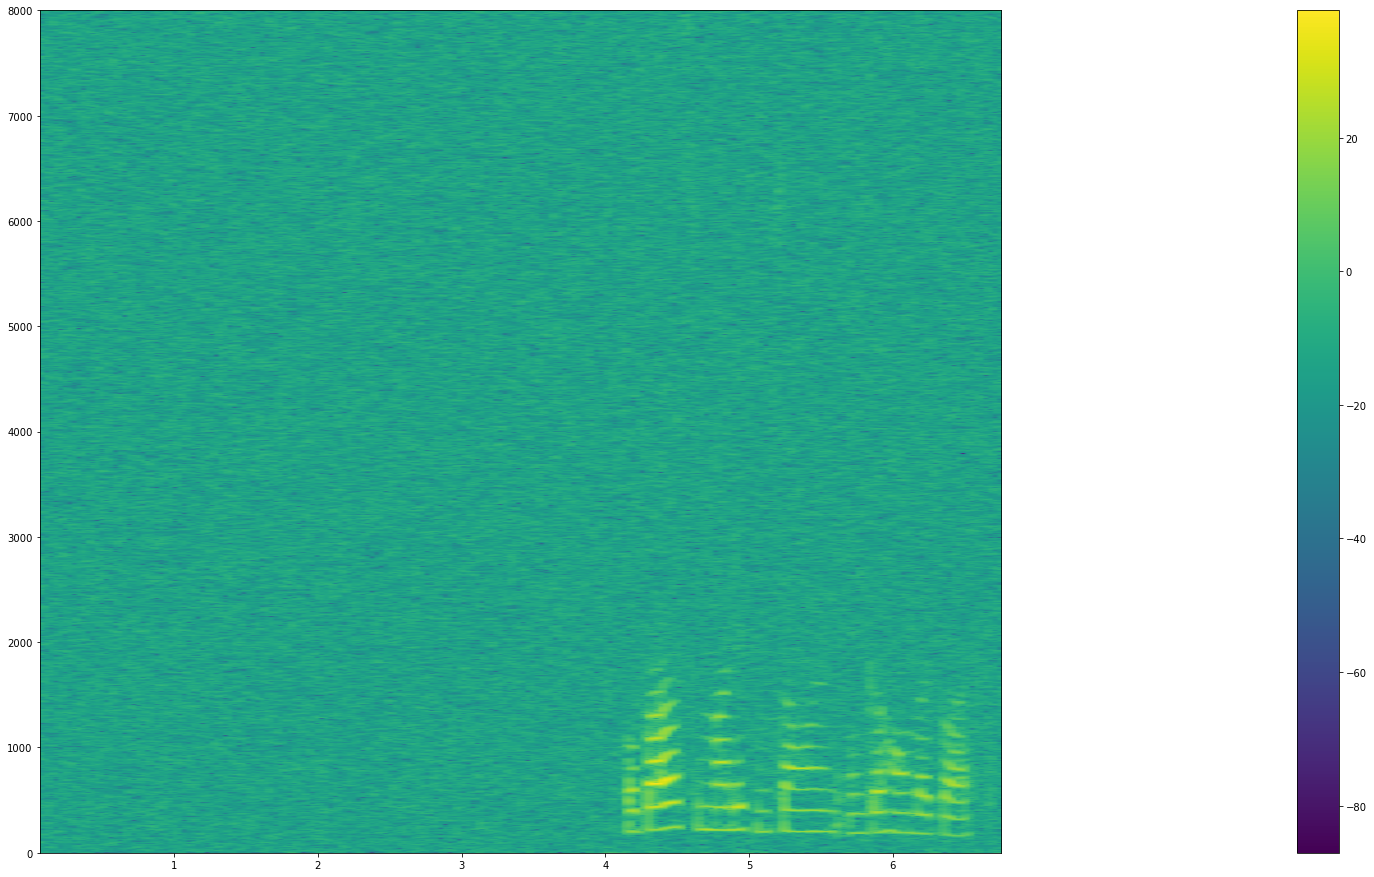

In [341]:
plot_spectrogram_nostft(s.T, v_time_frame_all[0], v_freq_all[0])

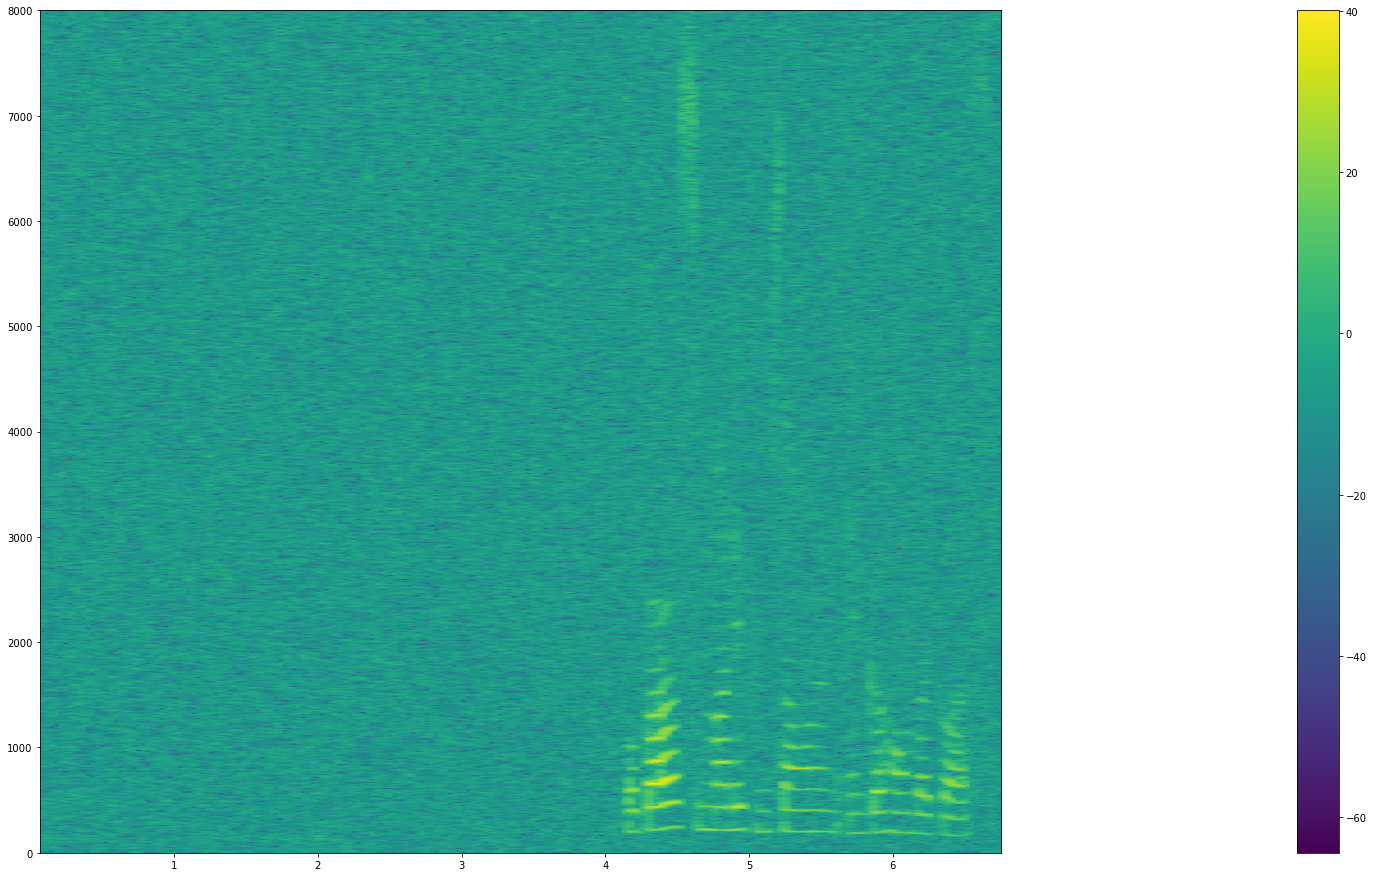

In [338]:
plot_spectrogram_nostft(m_stft_all[0], v_time_frame_all[0], v_freq_all[0])

In [342]:
def convert_to_samples(milliseconds: int, sampling_freq: int):
    """
    Convert a millisecond duration into the number of samples given the sampling frequency.

    :param milliseconds: duration to be converted to number of samples
    :param sampling_freq: the sampling frequency
    :return: number of samples
    """
    return int(milliseconds * (10 ** (-3)) * sampling_freq)

def compute_istft(stft: np.ndarray, sampling_rate: int, frame_shift: int, synthesis_window: np.ndarray) -> [np.ndarray]:
    """
    Compute the inverse short-time Fourier transform.

    :param stft: STFT transformed signal
    :param sampling_rate: the sampling rate in Hz
    :param frame_shift: the frame shift used to compute the STFT in milliseconds
    :param synthesis_window: a numpy array containing a synthesis window function (length must match with time domain
    signal segments that were used to compute the STFT)
    :return: a numpy array containing the time domain signal
    """

    # compute inverse rFFT and apply synthesis window
    time_frames = np.fft.irfft(stft)
    num_frames, samples_per_frame = time_frames.shape
    assert samples_per_frame == len(synthesis_window), "Synthesis window must match the number of samples per frame."
    time_frames *= synthesis_window

    # compute output size
    samples_per_shift = convert_to_samples(frame_shift, sampling_rate)
    output_len = samples_per_frame + (num_frames - 1) * samples_per_shift
    time_signal = np.zeros((output_len))


    # reconstruct signal by adding overlapping windowed segments
    for i in range(num_frames):
        time_signal[i*samples_per_shift:i*samples_per_shift+samples_per_frame] += time_frames[i]

    return time_signal

In [343]:
speech_estimate = compute_istft(s.T, sampling_rate, frame_shift, synthesis_window)

In [346]:
import sounddevice as sd
sd.play(noisy_sensor_data[:, 0], sampling_rate)

In [347]:
sd.play(speech_estimate, sampling_rate)